# 1. Подготовка обучающей выборки

In [1]:
import os
import sys
import pickle

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from collections import Counter
from tqdm import tqdm
from pandarallel import pandarallel

import pymorphy2
import nltk
from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize

import seaborn as sns
sns.set_style("whitegrid")

pd.set_option('display.max_colwidth', 255)
tqdm.pandas()
pandarallel.initialize(progress_bar=True, nb_workers=14, use_memory_fs=False)

SEED = 1

sys.path.append("..")
from src import *

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## 1. Загрузка данных 

In [2]:
abbr = pd.read_csv("../input/abbr_dict.csv", sep="\t")
lenta = pd.read_csv("../input/lenta-ru-news.csv")

<ipython-input-2-c300cdb3f553>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  lenta = pd.read_csv("../input/lenta-ru-news.csv")


## 2. Токенизация и лемматизация

Произведём предобработку входных данных с помощью токенизации и лематизации.

Для лематизации будем использовать только словарный анализатор для избежания искажения сокращений.

In [11]:
def tokenize(line):
    return word_tokenize(line)

morph = pymorphy2.MorphAnalyzer(lang="ru", 
                                units=[pymorphy2.units.DictionaryAnalyzer()])
def normalize(word):
    word = str(word).lower()
    parse_list = morph.parse(word)
    if parse_list != []:
        return parse_list[0].normal_form
    else:
        return word

def get_tokenized_normal_form(line):
    line = str(line)
    new_line_arr = []
    for token in tokenize(line):
        new_line_arr.append(normalize(token))
    return " ".join(new_line_arr)

In [4]:
abbr["desc_norm"] = abbr["desc"].parallel_apply(get_tokenized_normal_form)
abbr["desc_len"] = abbr["desc_norm"].str.split(" ").str.len()

In [5]:
abbr["abbr_norm"] = abbr["abbr"].parallel_apply(get_tokenized_normal_form)
abbr["abbr_len"] = abbr["abbr_norm"].str.split(" ").str.len()

In [14]:
%%time
lenta["text_norm"] = lenta["text"].parallel_apply(get_tokenized_normal_form)
lenta["text_len"] = lenta["text_norm"].str.split(" ").str.len()

CPU times: user 1min 5s, sys: 9.8 s, total: 1min 15s
Wall time: 23min 1s


In [17]:
REDUCE_COEF = 0.1
global_texts = (
    " " + 
    " ".join(lenta["text_norm"].sample(int(lenta.shape[0] * REDUCE_COEF), 
                                       random_state=SEED)
                               .to_list()) + 
    " "
)

abbr["abbr_count"] = abbr["abbr_norm"].parallel_apply(lambda x: global_texts.count(f" {x} "))
abbr["desc_count"] = abbr["desc_norm"].parallel_apply(lambda x: global_texts.count(f" {x} "))

In [20]:
abbr[(abbr.desc_count != 0) & (abbr.abbr_count != 0)]

,abbr,desc,tags,desc_norm,desc_len,abbr_norm,abbr_len,abbr_count,desc_count
12,СГД,Самарская губернская Дума,"гос., Самарская обл.",самарский губернский дума,3,сгд,1,10,3
28,замгенпрокурора,заместитель генерального прокурора,None,заместитель генеральный прокурор,3,замгенпрокурора,1,44,65
43,РС,реактивный снаряд,None,реактивный снаряд,2,рс,1,4,29
49,КК,комиссии и комитеты,None,комиссия и комитет,3,кк,1,1,1
66,НИ,«Новые известия»,издание,« новый известие »,4,ни,1,5254,2
...,...,...,...,...,...,...,...,...,...
85502,гост.,гостиница,None,гостиница,1,гост .,2,11,1228
85507,ПК,пластиковая карточка,None,пластиковый карточка,2,пк,1,86,1
85509,А,аэрозоль,None,аэрозоль,1,а,1,49131,31
85512,АА,армейская авиация,,армейский авиация,2,аа,1,6,31


## 3. Ограничение размеров 

### Тексты 

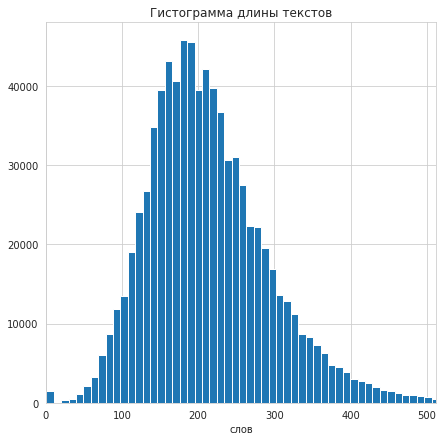

In [21]:
plt.figure(figsize=(7, 7))
lenta.text_len.hist(bins=1000)
plt.xlim(0, 512)
plt.title("Гистограмма длины текстов")
plt.xlabel("слов")
plt.show()

In [25]:
TEXT_LEN_MIN = 128
TEXT_LEN_MAX = 256

lenta_filt = lenta[lenta.text_len.between(TEXT_LEN_MIN, TEXT_LEN_MAX)]

print(lenta_filt.shape[0] / lenta.shape[0])

0.6295627204344705


### Сокращения 

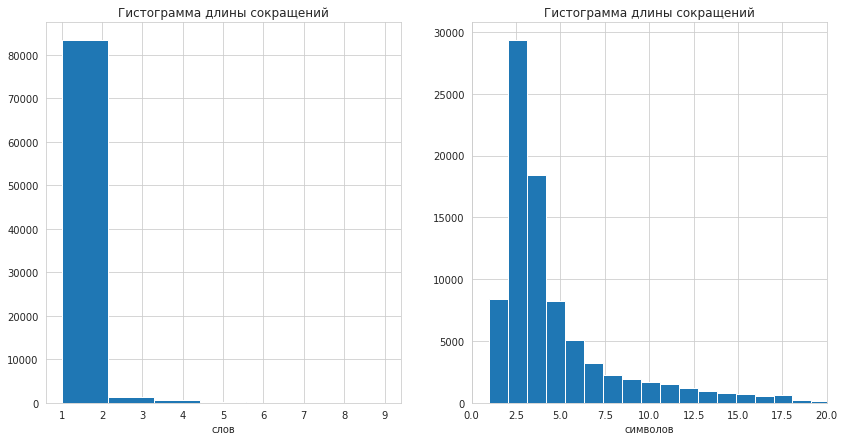

In [26]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
abbr.abbr_len.hist(bins=7)
plt.title("Гистограмма длины сокращений")
plt.xlabel("слов")

plt.subplot(1, 2, 2)
abbr["abbr_norm"].str.len().hist(bins=30)
plt.xlim(0, 20)
plt.title("Гистограмма длины сокращений")
plt.xlabel("символов")
plt.show()

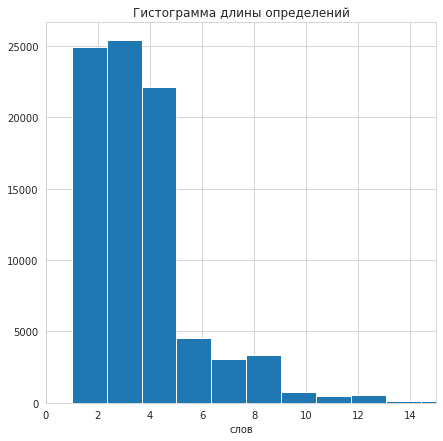

In [27]:
plt.figure(figsize=(7, 7))
abbr.desc_len.hist(bins=50)
plt.xlim(0, 15)
plt.title("Гистограмма длины определений")
plt.xlabel("слов")
plt.show()

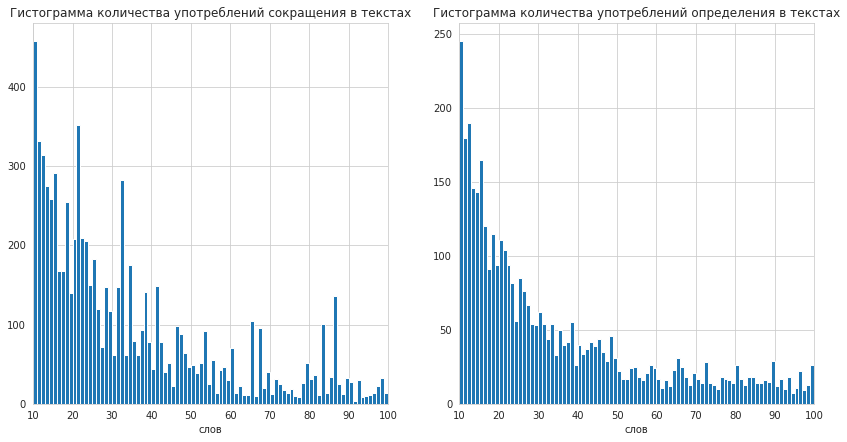

In [48]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
abbr[abbr["abbr_count"].between(10, 100)]["abbr_count"].hist(bins=90)
plt.xlim(10, 100)
plt.title("Гистограмма количества употреблений сокращения в текстах")
plt.xlabel("слов")

plt.subplot(1, 2, 2)
abbr[abbr["desc_count"].between(10, 100)]["desc_count"].hist(bins=90)
plt.xlim(10, 100)
plt.title("Гистограмма количества употреблений определения в текстах")
plt.xlabel("слов")
plt.show()

In [50]:
ABBR_LEN_MAX = 1
print("Abbr len filter", (abbr["abbr_len"] <= ABBR_LEN_MAX).sum() / abbr.shape[0])

DESC_LEN_MAX = 6
print("Desc len filter", (abbr["desc_len"] <= DESC_LEN_MAX).sum() / abbr.shape[0])

ABBR_CHAR_LEN_MIN = 2
print("Abbr char len filter", (abbr["abbr_norm"].str.len() >= ABBR_CHAR_LEN_MIN).sum() / abbr.shape[0])

abbr_detection = AbbrDetection()
print("Abbr detection filter", abbr["abbr_norm"].apply(abbr_detection.word_is_abbr).sum() / abbr.shape[0])

ABBR_MIN_COUNT_IN_TEXTS = 1
print("Abbr count filter", (abbr["abbr_count"] >= ABBR_MIN_COUNT_IN_TEXTS).sum() / abbr.shape[0])

DESC_MIN_COUNT_IN_TEXTS = 20
print("Desc count filter", (abbr["desc_count"] >= DESC_MIN_COUNT_IN_TEXTS).sum() / abbr.shape[0])

abbr_filt = abbr[(abbr["abbr_len"] <= ABBR_LEN_MAX) & 
                 (abbr["desc_len"] <= DESC_LEN_MAX) &
                 (abbr["abbr_norm"].str.len() >= ABBR_CHAR_LEN_MIN) &
                 (abbr["abbr_norm"].apply(abbr_detection.word_is_abbr)) &
                 (abbr["abbr_count"] >= ABBR_MIN_COUNT_IN_TEXTS) &
                 (abbr["desc_count"] >= DESC_MIN_COUNT_IN_TEXTS)]
print("ALL filter", abbr_filt.shape[0] / abbr.shape[0])
abbr_filt

Abbr len filter 0.8990121003098147
Desc len filter 0.9000526100426726
Abbr char len filter 0.9931490033319693
Abbr detection filter 0.8226573917109955
Abbr count filter 0.2843514350850529
Desc count filter 0.06342432922195593
ALL filter 0.013690302215467352


,abbr,desc,tags,desc_norm,desc_len,abbr_norm,abbr_len,abbr_count,desc_count
28,замгенпрокурора,заместитель генерального прокурора,None,заместитель генеральный прокурор,3,замгенпрокурора,1,44,65
43,РС,реактивный снаряд,None,реактивный снаряд,2,рс,1,4,29
169,ДМЗ,демилитаризованная зона,КНДР,демилитаризовать зона,2,дмз,1,1,34
207,МФО,международная финансовая организация,"организация, фин.",международный финансовый организация,3,мфо,1,85,21
209,РЖД,«Российские железные дороги»,"ж.-д., организация, РФ",« российский железный дорога »,5,ржд,1,627,24
...,...,...,...,...,...,...,...,...,...
85322,ПВН,продукция военного назначения,,продукция военный назначение,3,пвн,1,2,26
85350,СС,специальная служба,None,специальный служба,2,сс,1,86,21
85352,ТД,торговый дом,None,торговый дом,2,тд,1,10,43
85422,АК,авиационный комплекс,авиа,авиационный комплекс,2,ак,1,273,27


## 4. Сохранение 

In [52]:
abbr_filt.drop(["tags"], axis=1, inplace=True)
abbr_filt.drop_duplicates(["desc_norm", "abbr_norm"], inplace=True)
abbr_filt["abbr_id"] = np.arange(abbr_filt.shape[0])

abbr_filt.to_csv("../data/abbr.csv", index=False, header=True)

<ipython-input-52-d2bb80bd2f05>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abbr_filt.drop(["tags"], axis=1, inplace=True)
<ipython-input-52-d2bb80bd2f05>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abbr_filt.drop_duplicates(["desc_norm", "abbr_norm"], inplace=True)
<ipython-input-52-d2bb80bd2f05>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abbr_filt["abbr_id"] = n

In [53]:
lenta_filt.drop(["url", "title", "date"], axis=1, inplace=True)

lenta_filt.to_csv("../data/lenta.csv", index=False, header=True)

<ipython-input-53-fa5b7426f9ce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lenta_filt.drop(["url", "title", "date"], axis=1, inplace=True)
